In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns


In [2]:
with open('primed_qtable.json', 'r') as file:
    data = json.load(file)

In [3]:
data_df = pd.DataFrame(data)
data_df

,0,1,2,3,4,5,6
0,0.365173,0.559726,0.141548,0.542639,0.250596,0.543386,0.217198
1,0.635729,0.260287,0.468374,0.804615,0.124003,0.133389,0.381054
2,0.052111,0.652071,0.378817,0.007980,0.446736,0.338031,0.698959
3,0.351460,0.747562,0.871278,0.540300,0.687706,0.961985,0.247510
4,0.553277,0.856733,0.519581,0.791800,0.554725,0.440719,0.249968
...,...,...,...,...,...,...,...
5403,0.007015,0.132312,0.559844,0.448680,0.114912,0.270150,0.575708
5404,0.491385,0.198876,0.564334,0.793065,0.537193,0.783895,0.584540
5405,0.119218,0.723535,0.178792,0.942603,0.588687,0.152851,0.246724
5406,0.415744,0.673784,0.295270,0.913287,0.163536,0.008211,0.573983


In [4]:
import pickle
HEIGHT= 26
WIDTH = 26
def load_qtable(filename="qtable.pkl"):
    with open(filename, "rb") as f:
        qtable = pickle.load(f)
    return qtable

q_table = load_qtable()

In [5]:
q_table

,0,1,2,3,4,5,6
0,0.365173,0.559726,0.141548,0.542639,0.250596,0.543386,0.217198
1,0.635729,0.260287,0.468374,0.804615,0.124003,0.133389,0.381054
2,0.052111,0.652071,0.378817,0.007980,0.446736,0.338031,0.698959
3,0.351460,0.747562,0.871278,0.540300,0.687706,0.961985,0.247510
4,0.553277,0.856733,0.519581,0.791800,0.554725,0.440719,0.249968
...,...,...,...,...,...,...,...
5403,0.007015,0.132312,0.559844,0.448680,0.114912,0.270150,0.575708
5404,0.491385,0.198876,0.564334,0.793065,0.537193,0.783895,0.584540
5405,0.119218,0.723535,0.178792,0.942603,0.588687,0.152851,0.246724
5406,0.415744,0.673784,0.295270,0.913287,0.163536,0.008211,0.573983


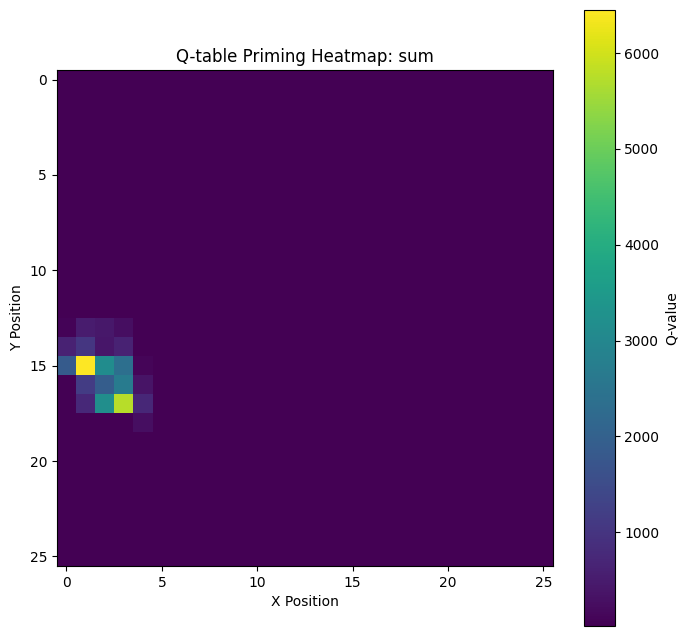

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_qtable_heatmap(qtable, mode="sum"):
    collapsed = np.zeros((HEIGHT, WIDTH))

    #encoding: ((((x,y)*2 + cart)*2 + items)*2 + checkout)

    for x in range(HEIGHT):
        for y in range(WIDTH):
            cell_value = 0
            # binary has_cart
            for cart in [0, 1]:
                # binary has_items
                for items in [0, 1]:
                    # binary has_checkour
                    for checkout in [0, 1]:
                        idx = ((((x*HEIGHT + y)*2 + cart)*2 + items)*2 + checkout)

                        if mode == "sum":
                            cell_value += qtable.loc[idx].sum() #sum of actions
                        elif mode == "max":
                            cell_value += qtable.loc[idx].max() #max of actions
                        else:
                            raise ValueError("mode wrong")

            collapsed[x, y] = cell_value

    plt.figure(figsize=(8, 8))
    plt.imshow(collapsed.T, origin="lower", aspect="equal")
    plt.colorbar(label="Q-value")
    
    ax = plt.gca()
    ax.invert_yaxis()

    plt.title(f"Q-table Priming Heatmap: {mode}")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.show()

plot_qtable_heatmap(qtable=q_table, mode="sum")
